In [1]:
from skimage.io import imread, imsave
from matplotlib import pyplot as plt

In [2]:
imgdir='/workspace/data/'

# if cropped tif not exists

In [4]:

img = imread(imgdir+'/PMD2057_N_0027.tif')

In [5]:
img.shape

(24000, 24000, 3)

In [6]:
img_crop = img[9800:14500,9000:14700]

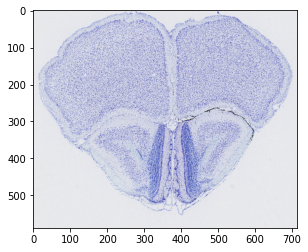

In [7]:
plt.imshow(img_crop[::8,::8,...])

In [8]:
img_crop.shape

(4700, 5700, 3)

In [9]:
imsave(imgdir+'/img_cropped.tif',img_crop)

# sample a tile

In [10]:
img_crop = imread(imgdir+'/img_cropped.tif')

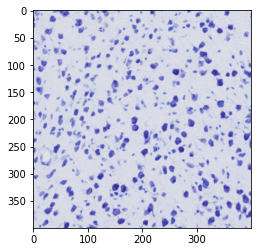

In [11]:
plt.imshow(img_crop[800:1200,800:1200])

# try inference

In [15]:
import sys
sys.path.append('../..')
from mrcnn.config import Config
import numpy as np

In [16]:
class NucleusConfig(Config):
    """Configuration for training on the nissl segmentation dataset. while using command "train"
    """
    # Give the configuration a recognizable name
    NAME = "nissl"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1 # since multiprocessing doesn't work

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + cell

    # Number of training and validation steps per epoch
    # 238 is the size of train set
    STEPS_PER_EPOCH = 218 // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = max(1, 20 // (IMAGES_PER_GPU * GPU_COUNT))

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nissl and BG
    DETECTION_MIN_CONFIDENCE = 0.7

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2, 4]

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # setting means for R and G to 0 since cells are mostly blue
    MEAN_PIXEL = np.array([0, 0, 103.9])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    IMAGE_CHANNEL_COUNT = 3

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 400

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 800
# In[5]:
class NucleusInferenceConfig(NucleusConfig):
    """Test-time configurations. while using command "test" or "detect"
    """
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9
    USE_MINI_MASK = False


In [17]:
config = NucleusInferenceConfig()

In [18]:
from mrcnn import model as modellib

Using TensorFlow backend.


In [19]:
model = modellib.MaskRCNN(mode='inference', config=config, model_dir='./logs')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [20]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [21]:
model.load_weights('mask_rcnn_nucleus_NISSL.h5', by_name=True)

# model forward

In [22]:
input_arr = img_crop[800:800+512,800:800+512]

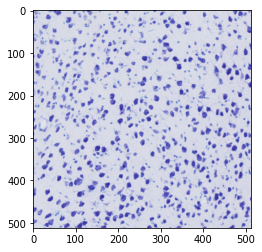

In [23]:
plt.imshow(input_arr)

In [31]:
r = model.detect([input_arr],verbose=1)

Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   24.10000  max:  237.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.50098  max:    1.37573  float32


In [32]:
type(r)

list

In [33]:
len(r)

2

In [34]:
type(r[0])

dict

In [35]:
r[0].keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

In [36]:
type(r[0]['masks'])

numpy.ndarray

In [37]:
r[0]['masks'].shape

(512, 512, 500)

In [38]:
out = r[0]['masks']

In [41]:
out.dtype

dtype('bool')

In [50]:
out_combined = out[...,0].astype(np.uint16)
for x in range(1,out.shape[-1]):
    out_combined += out[...,x].astype(np.uint16)*(x+1) 

In [51]:
x

499

In [52]:
out_combined.shape

(512, 512)

In [53]:
out_combined.max()

875

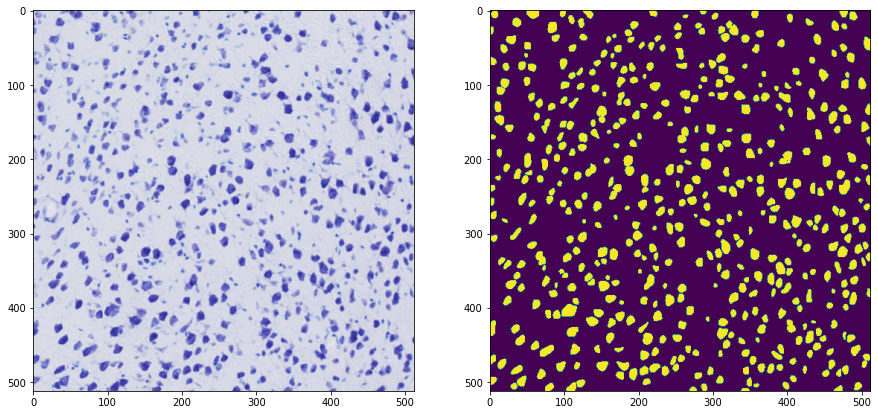

In [68]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(input_arr)
plt.subplot(1,2,2)
plt.imshow(out_combined>0)